In [1]:
import gc
import re
import pickle
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from pipelines import Pipeline
from utils import (
    camelcase_to_underscore, save_model, load_data, split_columns_by_types, kfold_with_respect_to_groups,
    reduce_mem_usage, Timer
)

%load_ext memory_profiler

In [2]:
df = load_data('train', 'input', sample_size=10000)
df.head()

Memory usage of dataframe is 2.21 MB
Memory usage after optimization is: 0.64 MB
Decreased by 71.1%


,id,group_id,match_id,assists,boosts,damage_dealt,dbn_os,headshot_kills,heals,kill_place,...,revives,ride_distance,road_kills,swim_distance,team_kills,vehicle_destroys,walk_distance,weapons_acquired,win_points,win_place_perc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [3]:
columns = split_columns_by_types(df)
display(df[columns['id']].head(), df[columns['target']].head())

,id,group_id,match_id
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6


0    0.444336
1    0.640137
2    0.775391
3    0.166748
4    0.187500
Name: win_place_perc, dtype: float16

Drop NaN target

In [4]:
df.drop(df[df['win_place_perc'].isnull()].index, inplace=True)

Train

In [5]:
%%time
%%memit
from lightgbm import LGBMModel
from sklearn.metrics import mean_absolute_error

from assess import assess


model_params = dict(
    objective='regression',
    metric='mae',
    n_jobs=-1,
    learning_rate=0.1,
    n_estimators=2000,
)
assessment_log = assess(
    LGBMModel(**model_params), 
    df, 
    columns,
    metrics=mean_absolute_error,
    n_splits=5,
    early_stopping_rounds=20,
    verbose=1,
)

/Users/dmitrymikhailovich_/cnt/pubg-kaggle/.direnv/python-3.6.3/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)



---------------------------
features.SimpleFeatureGenerator.transform 0:00:00.025366
features.GroupAggregatedFeatureGenerator.transform 0:00:00.205143
features.FeatureGenerator.transform 0:00:00.339408
preprocessing.Preprocessor.fit_transform 0:00:00.035222
pipelines.Pipeline.fit_transform: 0:00:00.426977
features.SimpleFeatureGenerator.transform 0:00:00.011346
features.GroupAggregatedFeatureGenerator.transform 0:00:00.085459
features.FeatureGenerator.transform 0:00:00.165725
preprocessing.Preprocessor.transform 0:00:00.006519
pipelines.Pipeline.transform: 0:00:00.221780
Data Preparation: 0:00:00.704916
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[152]	valid_0's l1: 0.0630485
Fitting: 0:00:01.086853
Saving: 0:00:00.128269
0.046741462288079405 0.06304854729744466
---------------------------


---------------------------
features.SimpleFeatureGenerator.transform 0:00:00.024346
features.GroupAggregatedFeatureGenerator.transform 0:00:00

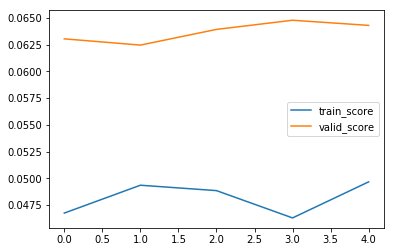

In [9]:
df_assessment = pd.DataFrame(assessment_log)
df_assessment[['train_score', 'valid_score']].plot()